In [1]:
import copy
from itertools import product
import itertools
from classification_refined import classify
from processing import *
from readfiles import *
from decision import filter_summary
from subgraphclass import make_solver_summary
from sklearn.model_selection import train_test_split
from classification_refined import *
import networkx as nx
from readfiles import *
from metrics import *
import numpy as np
import networkx as nx
import time 
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from readfiles import corresp_label_file
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import concurrent.futures
import time
from functools import partial
import os
from sklearn.svm import LinearSVC

In [2]:
def make_plot(node_names, target):
    cm = plt.cm.get_cmap('cool')
    fig, ax = plt.subplots(len(node_names.keys()), figsize=(35,10*len(node_names.keys())))
    for max_num_nodes, i in zip(node_names.keys(), range(len(node_names.keys()))):
        counts, bins, patches = ax[i].hist(node_names[max_num_nodes], 
                                           bins=len(pd.Series(node_names[max_num_nodes]).unique()))
        
        for c, p in zip(counts, patches):
            plt.setp(p, 'facecolor', cm(c/5))
    # Set the ticks to be at the edges of the bins.
        ax[i].set_title(f'{target} {max_num_nodes} nodes')
        ax[i].tick_params(labelrotation=55)
        ax[i].set_xticks(range(len(pd.Series(node_names[max_num_nodes]).unique())))
    plt.tight_layout()
    plt.savefig(f'outputs/{target}')
    #plt.show()

In [3]:
def find_node_indices(node_names): 
    original_node_indices = []
    original_node_nums = {v:k for k,v in corresp_label_file('fs_default.txt').items()}
    for node in node_names:
        original_node_indices.append(original_node_nums[node] -1)
        # now 0 corresponds to node 0
    mat = np.triu_indices(84)

    edge_indices = set()
    for u, v, i in zip(mat[0], mat[1], range(len(mat[0]))):
        for u1, v1 in itertools.product(original_node_indices, repeat = 2):
            if (u,v) == (u1, v1) or (v,u) == (u1,v1):
                edge_indices.add(i)
    #print(edge_indices)
    return list(edge_indices)


In [4]:
num = 84  # number of nodes in the graph
tri = int(num * (num + 1) * 0.5)  # we want only the upper diagonal due to symettry of connections
mat = np.triu_indices(84)
mews = '/home/skapoor/Thesis/gmwcs-solver'

In [5]:
num_nodes = [15,20]

In [6]:
feature, edge, solver_node_wts = 'num_streamlines', 'fscores','const'
val, thresh = -0.01, 0
choice, classifier, refit_metric, feature_selection = 'random', 'none', 'balanced_accuracy', 'baseline'
baseline_cases, self_loops = set(), False

In [7]:

'''labels = ['ReadEng_Unadj', 'ReadEng_AgeAdj',  'PicVocab_Unadj', 
          'PicVocab_AgeAdj','ProcSpeed_Unadj', 'ProcSpeed_AgeAdj', 
          'PicSeq_Unadj','PicSeq_AgeAdj', 'CardSort_Unadj', 'CardSort_AgeAdj',
'Flanker_Unadj','Flanker_AgeAdj', 'PMAT24_A_CR', 'VSPLOT_TC', 'IWRD_TOT',  'ER40_CR']'''
labels = ['ER40_CR']

ER40_CR
StratifiedKFold(n_splits=5, random_state=22, shuffle=True) ----------------------------------------------------------------------------------------------------
Number of nodes 15
Time for fold 1: 2.228
Time for fold 2: 2.149
Time for fold 3: 2.254
Time for fold 4: 2.296
Time for fold 5: 2.261
Number of nodes 20
Time for fold 1: 2.276
Time for fold 2: 2.126
Time for fold 3: 2.187
Time for fold 4: 2.2
Time for fold 5: 2.203


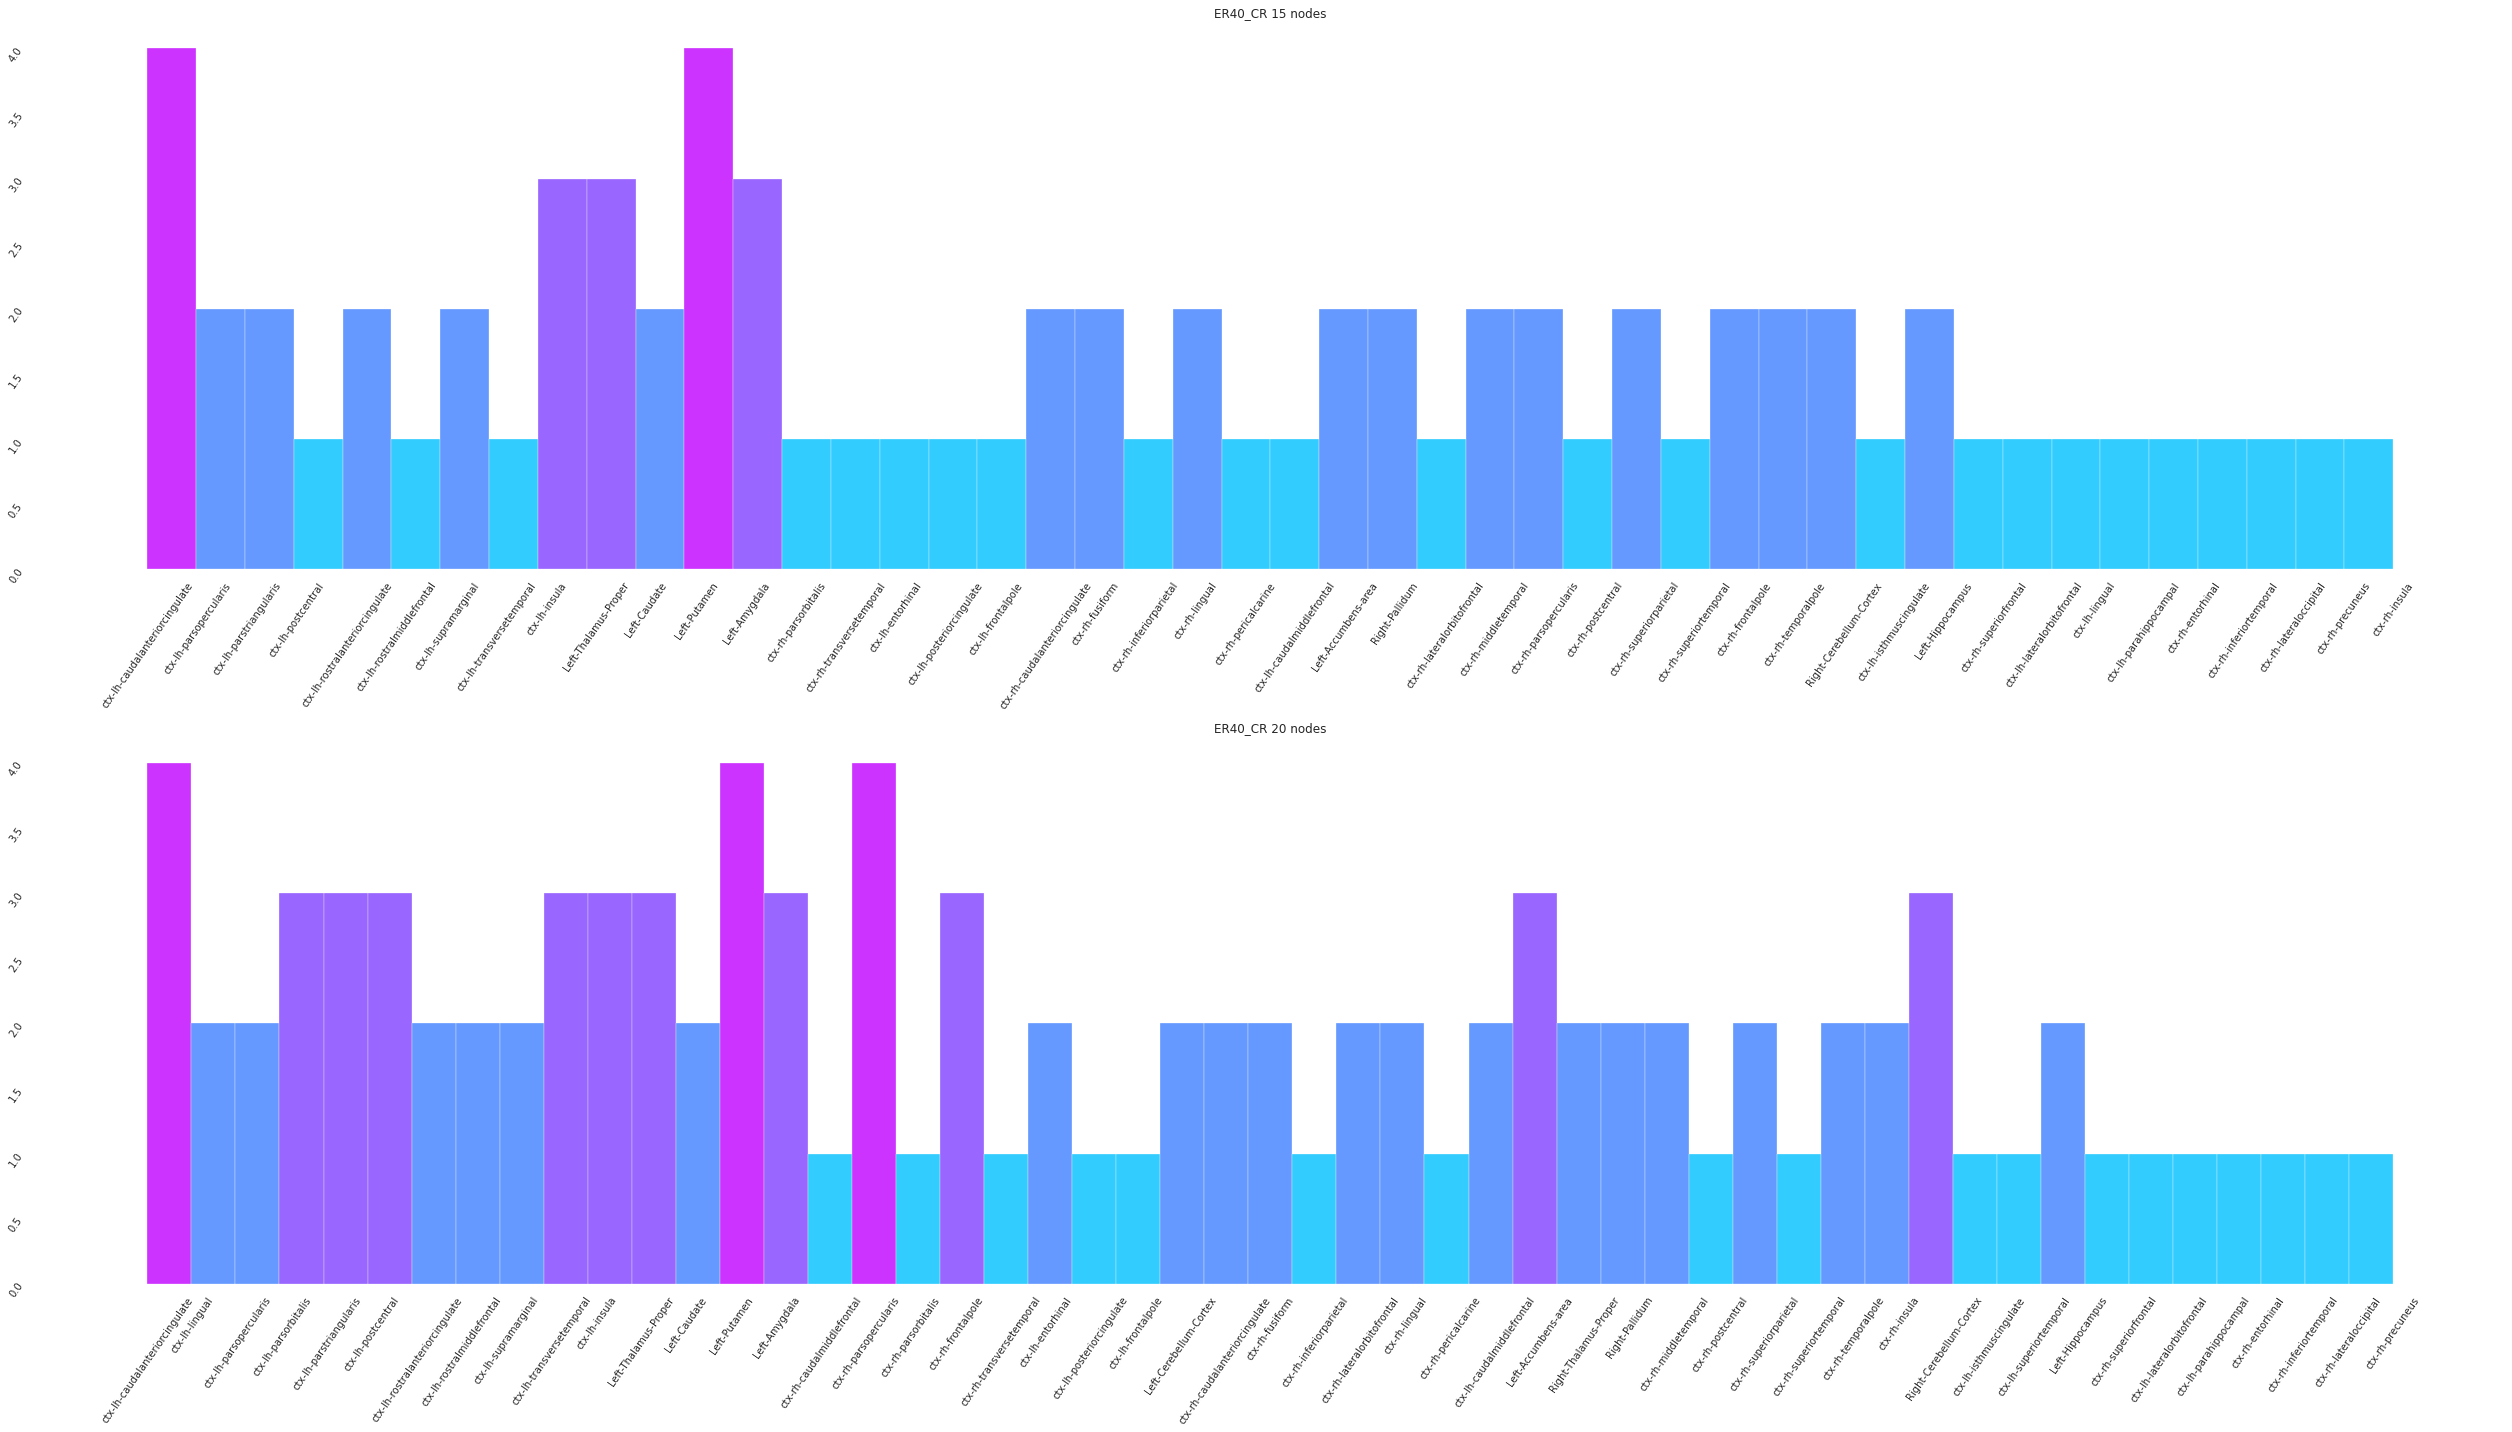

In [8]:

# note: right now the matrix whole is not scaled, for computing the fscores and correlation coeff it has to be so.
y_tr, y_te = computed_subjects(), test_subjects()

labels = [label for label in labels if label in y_tr.columns]

X_tr = generate_combined_matrix(tri, list(y_tr.index))  # need to check indices till here then convert to numpy array
X_te = generate_test_data(tri, y_te.index)
X_tr, X_te = edge_filtering(feature, X_tr, X_te)
X = X_tr.append(X_te)
results = {}
for target in labels:
    results[target] = {}
    print(f'{target}')
    y_train_l, y_test_l = y_tr[target], y_te[target]
    y =  y_train_l.append(y_test_l)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state = 22)
    y_binned = pd.qcut(y, 5, labels=False, retbins=True)[0]

    skf.get_n_splits(X, y_binned)
    print(skf, '-'*100)
    results_solver = []
    avg_thresh, self_loops = False, False
    #nodes = []
    node_names = {k:[] for k in num_nodes}
    param_grid = [{'alpha': [10, 1e3]}]
    for max_num_nodes in num_nodes:
        
        results[target][max_num_nodes] = {}
        print(f"Number of nodes {max_num_nodes}")
        i = 0 
        for train_index, test_index in skf.split(X, y_binned):
            
            i += 1
            results[target][max_num_nodes][i] = {}
            start = time.time()
            #print("TRAIN:",len(train_index), train_index, "TEST:", len(test_index),test_index)
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            med = y_train.median()
            y_train_l = pd.qcut(y_train, 5, labels=False, retbins=True)[0]
            # we need to pass the non-binned values for effective pearson correlation calc.
            # print('The number of training subjects which are to be removed:', sum(y_train_l == 2))
            y_train_l = y_train_l[y_train_l != 2]
            y_train_l = y_train_l // 3  # binarizing the values by removing the middle quartile
            y_test_l = y_test >= med 
            X_train_l = X_train.loc[y_train_l.index]
            assert list(X_train_l.index) == list(y_train_l.index)
            X_train_l, X_test_l, arr = process_raw(X_train_l, X_test, y_train_l, edge)
            graph = np.zeros((84,84))

            for k,j ,l in zip(np.triu_indices(84)[0], np.triu_indices(84)[1], range(tri)):
                graph[k,j] = abs(arr.iloc[l]) #  taking the absolute value of the pearson correlation 
            # graph is currently upper triangular and needs to be converted into full matrix
            graph = graph + graph.transpose() - 2 * np.diag(graph.diagonal()) # excluding the diagonal
            graph = pd.DataFrame(graph, index = corresp_label_file('fs_default.txt').values(), 
                         columns = corresp_label_file('fs_default.txt').values())

            while len(graph.iloc[0]) > max_num_nodes:
                node = graph.sum(axis=1).argmin()
                graph = graph.drop([graph.loc[node].name], axis = 0) # returns the row as series
                graph = graph.drop(graph.loc[:, node].name, axis = 1) # graph.loc[:, node].name
            node_names[max_num_nodes].extend(list(graph.columns))
            end = time.time()
            t = end - start
            edge_indexes = find_node_indices(graph.columns)
            
            print(f'Time for fold {i}:', round(t,3))
            for classifier in ['SVC']:
                
                clf = LinearSVC(C = 1e-20, random_state = 22, tol= 1e-15, loss = 'hinge')
                
                results[target][max_num_nodes][i][classifier] = {}
                clf.fit(X_train_l.iloc[:, edge_indexes], y_train_l)
                test_results =  clf.score(X_test_l.iloc[:, edge_indexes], y_test_l)
                train_results = clf.score(X_train_l.iloc[:, edge_indexes], y_train_l)
                results[target][max_num_nodes][i][classifier] = {'train': train_results, 'test': test_results}
    make_plot(node_names, target)

In [10]:
results

{'ER40_CR': {15: {1: {'SVC': {'train': 0.7424242424242424,
     'test': 0.36585365853658536}},
   2: {'SVC': {'train': 0.7348484848484849, 'test': 0.4878048780487805}},
   3: {'SVC': {'train': 0.7878787878787878, 'test': 0.36585365853658536}},
   4: {'SVC': {'train': 0.6893939393939394, 'test': 0.5}},
   5: {'SVC': {'train': 0.7651515151515151, 'test': 0.425}}},
  20: {1: {'SVC': {'train': 0.7803030303030303, 'test': 0.4634146341463415}},
   2: {'SVC': {'train': 0.8106060606060606, 'test': 0.5121951219512195}},
   3: {'SVC': {'train': 0.8181818181818182, 'test': 0.43902439024390244}},
   4: {'SVC': {'train': 0.7348484848484849, 'test': 0.4}},
   5: {'SVC': {'train': 0.7803030303030303, 'test': 0.5}}}}}

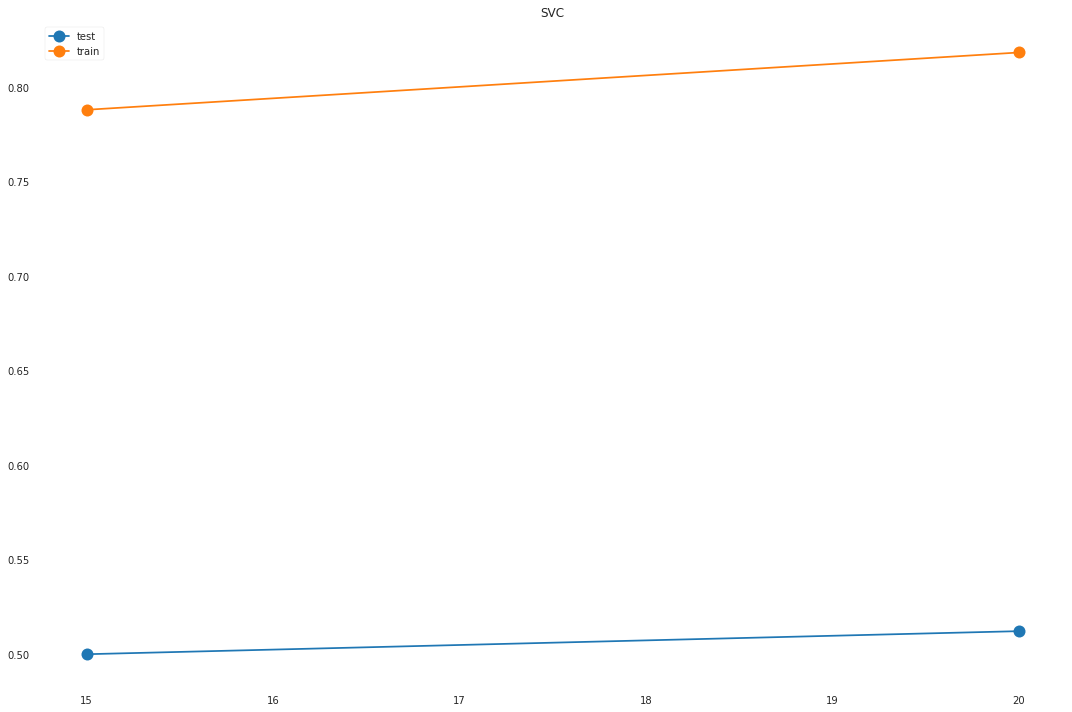

In [9]:
fig, ax = plt.subplots(figsize = (15,10), sharex = True, sharey = True)
for clf in ['SVC']:
    ax.set_title(clf)
    ax.plot(num_nodes,
             [np.max([results['ER40_CR'][node][k][clf]['test'] 
               for k in range(1,6)]) for node in num_nodes], marker = 'o', markersize = 12, label= 'test')
    ax.plot(num_nodes,
             [np.max([results['ER40_CR'][node][k][clf]['train']
               for k in range(1,6)]) for node in num_nodes], marker = 'o', markersize = 12, label = 'train')
plt.legend()
plt.tight_layout()